In [37]:
import pandas as pd
import geopandas as gpd
from siuba import *

# from segment_speed_utils import gtfs_schedule_wrangling, helpers, segment_calcs,sched_rt_utils
from segment_speed_utils.project_vars import (
    COMPILED_CACHED_VIEWS,
    PROJECT_CRS,
    SEGMENT_GCS,
)
import datetime as dt

In [2]:
import shared_utils

In [3]:
from shared_utils.rt_utils import MPH_PER_MPS

In [4]:
target_mph = 16
target_mps = target_mph / MPH_PER_MPS

In [5]:
SEGMENT_GCS

'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/'

In [6]:
# analysis_date = shared_utils.rt_dates.DATES['mar2023']
analysis_date = shared_utils.rt_dates.DATES['sep2022a']

In [7]:
#  from Oct 12 22 RtFilterMapper run, handy to use as a clip geom too
corr = gpd.read_parquet('../rt_delay/lincoln_oct12_old.parquet')

In [8]:
def get_bbb_feed(analysis_date):

    feeds = shared_utils.gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name(analysis_date)
    bbb_feed = feeds >> filter(_.gtfs_dataset_name.str.contains('Big Blue'))
    return bbb_feed

# bbb_dataset_key = bbb_feed.gtfs_dataset_key.iloc[0]
# bbb_feed_key = bbb_feed.feed_key.iloc[0]

In [9]:
# mar23 = pd.read_parquet(f'{SEGMENT_GCS}speeds_stop_segments_{analysis_date}.parquet')

In [10]:
# mar23_shape = pd.read_parquet(f'{SEGMENT_GCS}segment_options/shape_stop_segments_{analysis_date}.parquet')

In [11]:
def get_shapes(analysis_date, bbb_feed):
    shapes = pd.read_parquet(f'{SEGMENT_GCS}segment_options/shape_stop_segments_{analysis_date}.parquet')
    bbb_shapes = shapes >> filter(_.schedule_gtfs_dataset_key == bbb_feed.gtfs_dataset_key.iloc[0])
    bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)
    bbb_shapes = gpd.GeoDataFrame(bbb_shapes, geometry=bbb_shapes.geometry, crs=PROJECT_CRS)
    return bbb_shapes

In [12]:
def get_speeds(analysis_date, bbb_feed):
    speeds = pd.read_parquet(f'{SEGMENT_GCS}speeds_stop_segments_{analysis_date}.parquet')
    bbb_speeds = (speeds >> filter(_.schedule_gtfs_dataset_key == bbb_feed.gtfs_dataset_key.iloc[0])
                     >> select(_.speed_mph, _.meters_elapsed, _.sec_elapsed, _.trip_instance_key, _.stop_sequence)
                 )
    return bbb_speeds

In [13]:
bbb_feed = get_bbb_feed(analysis_date)

bbb_speeds = get_speeds(analysis_date, bbb_feed)

bbb_shapes = get_shapes(analysis_date, bbb_feed)

/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


In [14]:
lincoln_trips = shared_utils.gtfs_utils_v2.get_trips(selected_date=analysis_date,
                                                 operator_feeds=[bbb_feed.feed_key.iloc[0]],
                                                custom_filtering = {'route_short_name': ['3', 'R3']})
lincoln_trips = lincoln_trips >> select(_.trip_instance_key, _.route_short_name, _.trip_first_departure_ts)

lincoln_shapes = bbb_shapes >> inner_join(_, lincoln_trips, on = ['trip_instance_key'])

lincoln_shapes = lincoln_shapes >> inner_join(_, bbb_speeds, on=['trip_instance_key', 'stop_sequence'])

In [15]:
lincoln_shapes >> count(_.trip_instance_key)

,trip_instance_key,n
0,00cb2b6a9bb2cc1c34fd971c07938524,15
1,03dae18652b59eab34279c4b045fcf0a,16
2,04cf84b10b7b261d3e78365770224208,36
3,057a9fd5ca744a324a9e53e91cb89410,35
4,05bf3463796e8717f8101f6bc357f553,36
...,...,...
177,fbea7e14d2bcf757eb9affdb036d80f2,36
178,fc8c9b9d82411b4a7c7b0eca245115d1,35
179,fd10910bc6f254fca030507f440969b0,35
180,fd1351cb7af965ee68969e90ecc38a6f,35


In [16]:
lincoln_shapes['target_sec_elapsed'] = lincoln_shapes.meters_elapsed / target_mps

assert lincoln_shapes.crs == corr.crs

lincoln_clipped = gpd.clip(lincoln_shapes, corr)

lincoln_clipped['speed_delay'] = (lincoln_clipped.sec_elapsed - lincoln_clipped.target_sec_elapsed).clip(lower=0)

In [17]:
# (lincoln_clipped >> select(-_.trip_first_departure_ts)
#     >> filter(_.trip_instance_key == '08c415d5ca6ef9453381b97dcc2c1b58')
# ).explore()

In [18]:
lincoln_clipped.speed_delay.sum() / 60

1414.6234172088684

In [83]:
def lincoln_corridor_delay(analysis_date):
    
    # print(analysis_date)
    bbb_feed = get_bbb_feed(analysis_date)
    bbb_speeds = get_speeds(analysis_date, bbb_feed)
    bbb_shapes = get_shapes(analysis_date, bbb_feed)
    
    lincoln_trips = shared_utils.gtfs_utils_v2.get_trips(selected_date=analysis_date,
                                                 operator_feeds=[bbb_feed.feed_key.iloc[0]],
                                                custom_filtering = {'route_short_name': ['3', 'R3']})
    lincoln_trips = lincoln_trips >> select(_.trip_instance_key, _.route_short_name, _.trip_first_departure_ts)
    sched_trip_count = lincoln_trips.shape[0]

    lincoln_shapes = bbb_shapes >> inner_join(_, lincoln_trips, on = ['trip_instance_key'])

    lincoln_shapes = lincoln_shapes >> inner_join(_, bbb_speeds, on=['trip_instance_key', 'stop_sequence'])
    print((lincoln_shapes >> count(_.trip_instance_key)).shape)
    assert not lincoln_shapes.empty
    rt_trip_count = (lincoln_shapes >> count(_.trip_instance_key)).shape[0]
    
    lincoln_shapes['target_sec_elapsed'] = lincoln_shapes.meters_elapsed / target_mps
    assert lincoln_shapes.crs == corr.crs
    lincoln_clipped = gpd.clip(lincoln_shapes, corr)
    lincoln_clipped['speed_delay'] = (lincoln_clipped.sec_elapsed - lincoln_clipped.target_sec_elapsed).clip(lower=0)
    delay_minutes = lincoln_clipped.speed_delay.sum() / 60
    
    return (analysis_date, delay_minutes, rt_trip_count, rt_trip_count / sched_trip_count)

In [84]:
lincoln_corridor_delay(analysis_date)

/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(107, 2)


('2024-04-21', 759.0243040335821, 107, 0.8294573643410853)

In [85]:
test = list(shared_utils.rt_dates.DATES.keys())[15:20]

In [89]:
def compile_lincoln_delays():
    lincoln_delays = []
    for date in shared_utils.rt_dates.DATES.keys():
    # for date in test:
        analysis_date = shared_utils.rt_dates.DATES[date]
        print(analysis_date)
        try:
            lincoln_delays += [lincoln_corridor_delay(analysis_date)]
        except:
            print(f'failed for {analysis_date}')
    # return lincoln_delays
    lincoln_delay_df = pd.DataFrame(lincoln_delays,
                                    columns=['date_str', 'delay_minutes', 'vp_trip_count',
                                             'vp_pct_sched'])
    lincoln_delay_df['date'] = lincoln_delay_df.date_str.apply(lambda x: dt.datetime.fromisoformat(x).date())
    lincoln_delay_df['weekday'] = lincoln_delay_df.date.apply(lambda x: x.strftime('%a'))
    # df = df >> filter(-_.weekday.isin(['Sat', 'Sun', 'Mon', 'Fri']))
    return lincoln_delay_df

In [90]:
lincoln_delay_df = compile_lincoln_delays()

2022-02-08
failed for 2022-02-08
2022-03-30
failed for 2022-03-30
2022-05-04
failed for 2022-05-04
2022-06-15
failed for 2022-06-15
2022-07-13
failed for 2022-07-13
2022-08-17
failed for 2022-08-17
2022-09-14
failed for 2022-09-14
2022-09-21


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(182, 2)
2022-10-12
failed for 2022-10-12
2022-11-07
failed for 2022-11-07
2022-11-08
failed for 2022-11-08
2022-11-09
failed for 2022-11-09
2022-11-10
failed for 2022-11-10
2022-11-16
failed for 2022-11-16
2022-12-14
failed for 2022-12-14
2023-01-18
failed for 2023-01-18
2023-02-15
failed for 2023-02-15
2023-03-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(156, 2)
2023-04-10


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(153, 2)
2023-04-11


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(145, 2)
2023-04-12


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(160, 2)
2023-04-13


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(146, 2)
2023-04-14


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(155, 2)
2023-04-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(125, 2)
2023-04-16


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(129, 2)
2023-05-17


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(144, 2)
2023-06-14


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(144, 2)
2023-07-12


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(162, 2)
2023-08-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(160, 2)
2023-08-23
failed for 2023-08-23
2023-09-13


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(147, 2)
2023-10-09


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(148, 2)
2023-10-10


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(153, 2)
2023-10-11


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(157, 2)
2023-10-12


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(152, 2)
2023-10-13


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(150, 2)
2023-10-14


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(129, 2)
2023-10-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(129, 2)
2023-11-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(151, 2)
2023-12-13


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(155, 2)
2024-01-17


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(144, 2)
2024-02-14


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(152, 2)
2024-03-13


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(153, 2)
2024-04-15


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(158, 2)
2024-04-16


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(137, 2)
2024-04-17


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(134, 2)
2024-04-18


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(74, 2)
2024-04-19


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(123, 2)
2024-04-20


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(120, 2)
2024-04-21


/tmp/ipykernel_174898/1351526470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbb_shapes.geometry = gpd.GeoSeries.from_wkb(bbb_shapes.geometry)


(107, 2)


In [96]:
lincoln_delay_df = lincoln_delay_df >> filter(_.vp_pct_sched > .8)

In [97]:
lincoln_delay_df['delay_per_trip'] = lincoln_delay_df.delay_minutes / lincoln_delay_df.vp_trip_count

/tmp/ipykernel_174898/1409579010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lincoln_delay_df['delay_per_trip'] = lincoln_delay_df.delay_minutes / lincoln_delay_df.vp_trip_count


In [98]:
lincoln_delay_df = lincoln_delay_df >> filter(-_.weekday.isin(['Sat', 'Sun', 'Mon', 'Fri']))

<AxesSubplot:xlabel='date', ylabel='delay_per_trip'>

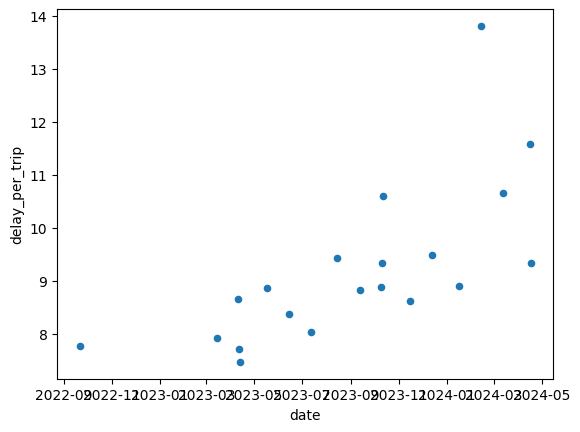

In [99]:
lincoln_delay_df.plot.scatter('date', 'delay_per_trip')

In [100]:
lincoln_delay_df

,date_str,delay_minutes,vp_trip_count,vp_pct_sched,date,weekday,delay_per_trip
0,2022-09-21,1414.623417,182,0.928571,2022-09-21,Wed,7.772656
1,2023-03-15,1237.075534,156,0.962963,2023-03-15,Wed,7.929971
3,2023-04-11,1254.466843,145,0.895062,2023-04-11,Tue,8.651495
4,2023-04-12,1234.140576,160,0.987654,2023-04-12,Wed,7.713379
5,2023-04-13,1090.717845,146,0.901235,2023-04-13,Thu,7.470670
9,2023-05-17,1276.081033,144,0.888889,2023-05-17,Wed,8.861674
10,2023-06-14,1206.520870,144,0.888889,2023-06-14,Wed,8.378617
11,2023-07-12,1302.071853,162,1.000000,2023-07-12,Wed,8.037481
12,2023-08-15,1508.928380,160,0.987654,2023-08-15,Tue,9.430802
13,2023-09-13,1297.524248,147,0.907407,2023-09-13,Wed,8.826696


In [102]:
import altair as alt

In [110]:
lincoln_delay_df.date = lincoln_delay_df.date.apply(lambda x: pd.Timestamp(x))

In [119]:
chart = alt.Chart(lincoln_delay_df).mark_point().encode(
    x='date:T',
    y='delay_per_trip'
).properties(width=500, height=400)

chart + chart.transform_regression('date', 'delay_per_trip').mark_line()

alt.LayerChart(...)

In [116]:
lincoln_delay_df.to_csv('lincoln_delays_preliminary.csv')